In [1]:
# # Installing libraries without a specific version
# ! pip install tensorflow
# ! pip install zfit==0.5.6 
# ! pip install mplhep
# ! pip install pandas
# ! pip install scipy==1.4.1

# # Installed scikit-gof
# !pip install scikit-gof

In [2]:
# !pip install scipy==1.4.1

In [3]:
# scipy.__version__

In [4]:
# ! pip install seaborn

# Setup

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline 
import tensorflow as tf
import zfit
import numpy as np
import mplhep

2022-08-08 16:46:43.115124: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-08 16:46:43.115283: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/carlos/anaconda3/envs/zfit_latest/lib/python3.8/site-packages/zfit/__init__.py:50: UserWarning: This is an ALPHA version of zfit for feature testing, do NOT use it in production! It is NOT stable and contains bugs and untested features. For production use, please use the last beta stable version of zfit.
  warnings.warn(
/home/carlos/anaconda3/envs/zfit_latest/lib/python3.8/site-packages/zfit/__init__.py:62: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings A

In [6]:
import time

In [7]:
# Following https://stackoverflow.com/a/64604031
import sys

from pathlib import Path

In [8]:
# in jupyter (lab / notebook), based on notebook path
module_path = str(Path.cwd().parents[2]/"scripts")

if module_path not in sys.path:
    sys.path.append(module_path)
    
data_path = str(Path.cwd().parents[2] / "data" / "Efficiency" )

exp_data_path = str(Path.cwd().parents[2] / "data" / "EfficiencyData")

In [9]:
# Modules made by Horacio

import zfitEffy
import customPDFs
import plot_tools
import tools

2022-08-08 16:46:50.993789: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-08 16:46:50.993908: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-08 16:46:50.993950: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-KJ9UEOTB): /proc/driver/nvidia/version does not exist


In [10]:
import re

In [11]:
from math import ceil

In [12]:
from scipy.stats import norm
import matplotlib.pyplot as plt

In [13]:
from scipy import stats
from skgof import ks_test, cvm_test, ad_test

/home/carlos/anaconda3/envs/zfit_latest/lib/python3.8/site-packages/skgof/ecdfgof.py:45: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  from .cvmdist import cvm_unif


## Helper functions

In [14]:
# Reading Horacio's format for Bernstein polynomials

def read_single_berntsein_polynomial(obs, params, name='', fixed_params=True):

    if type(params)==str:
        with open(params, 'r') as jj: params = json.load(jj)
        
    coefs_names = [k for k in params.keys() if 'c^' in k] 
    deg, ordered_coefs = get_degree(coefs_names)
    if not fixed_params:
        coefs = [zfit.Parameter(f'{name}c^{i}_{deg}', params[c]['value']) for i, c in enumerate(ordered_coefs)]
        return customPDFs.bernstein(coefs, obs, name)
    else:
        coefs = [ params[c]['value'] for c in ordered_coefs]
        return customPDFs.bernstein(coefs, obs, name)

In [15]:
# Helper function to get the degree of the polynomial for 
# 'read_single_berntsein_polynomial'

def get_degree(coefs_names, type_=''):
    search_degree = [re.search(r'_[0-9]+', coef) for coef in coefs_names]
    search_coef_n = [re.search(r'\^[0-9]+_', coef.replace(type_, '')) for coef in coefs_names]
    degrees = [int(match.group(0).replace('_', '')) for match in search_degree]
    coefs   = [int(match.group(0).replace('_', '').replace(r'^', '')) for match in search_coef_n]
    if len(set(coefs))==1 and degrees[0]!=0:
        search_coef_n = [re.search(r'[0-9]+_', coef) for coef in coefs_names]
        coefs   = [int(match.group(1).replace('_', '')) for match in search_coef_n]  
          
    if not len(set(degrees))==1:
        raise NotImplementedError(f'More than one degree in yur coefs!\n{coefs_names}\nCheck them')
    
    names_ = np.array(coefs_names, dtype='O')
    return degrees[0], names_[np.array(coefs).argsort()]

# Example: Norm model

In [16]:
model=norm()

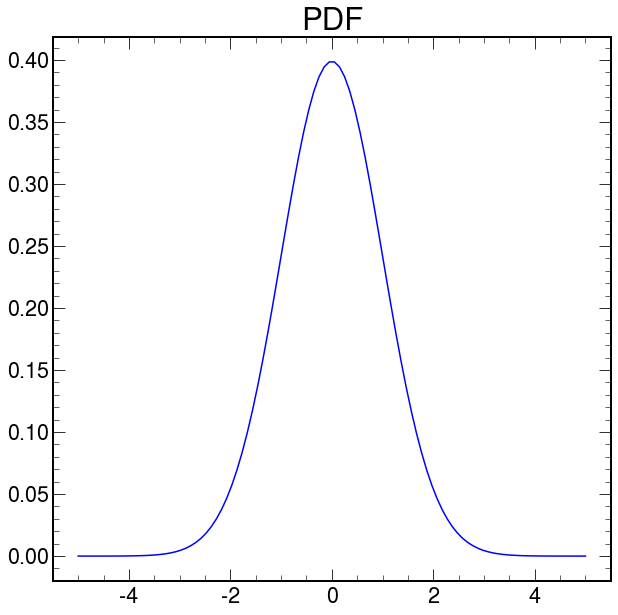

In [17]:
# Returns the pdf
def f(x):
    return model.pdf(x)

# Makes linspace from -5 to 5 for plot
x = np.linspace(-5, 5, 100)

# Plots the PDF
plt.title('PDF')
plt.plot(x, f(x), color='blue')

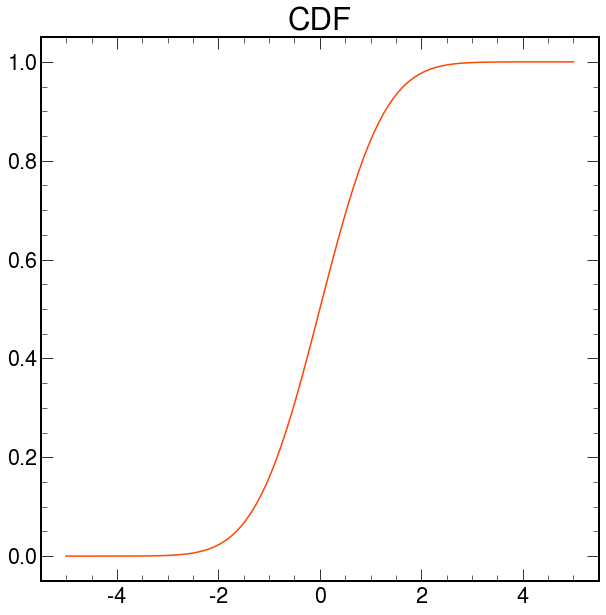

In [18]:
#Prints the cumulative function distribution
def g(y):
    return model.cdf(y)

#Plot with the same linspace
plt.title('CDF')
plt.plot(x, g(x), color='orangered')

In [19]:
# Generating a sample of data: 

n_samp = 1000

sampler=[]
for i in range (0,n_samp):
    sampler.append(model.rvs(size=10000)) #this generates random variates (random variables)


Text(0.5, 1.0, 'example-sampler, 100 bins')

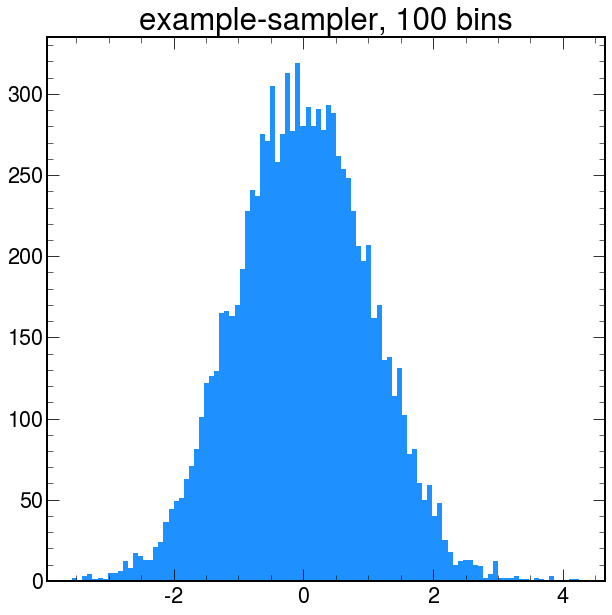

In [20]:
plt.hist(sampler[9],100,color='dodgerblue')
plt.title('example-sampler, 100 bins')

In [21]:
import scipy
from scipy import stats
from skgof import ks_test, cvm_test, ad_test

In [22]:
pvalues=[]
statistics=[]
for i in range (0,n_samp):
    pvalues.append(ks_test(sampler[i],model).pvalue)
    statistics.append(ks_test(sampler[i],model).statistic)

Text(0.5, 1.0, 'statistic form gaussian, scikit-gof')

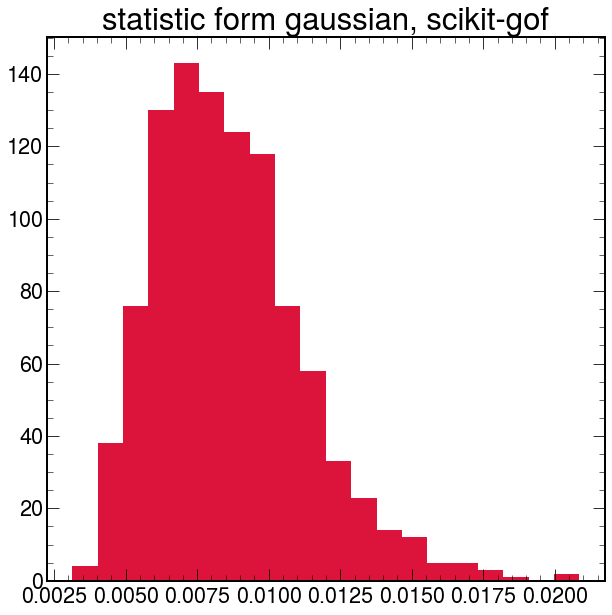

In [23]:
hist=plt.hist(statistics,bins=20,color='crimson')
plt.title('statistic form gaussian, scikit-gof')

Text(0.5, 1.0, 'pvalues from gaussian, scikit')

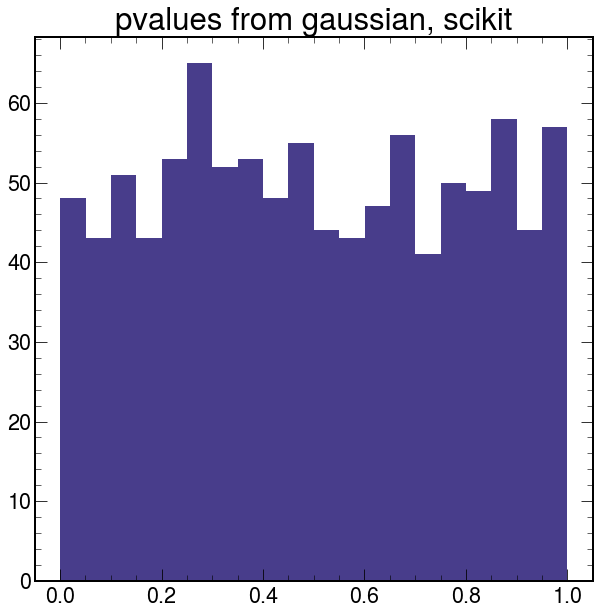

In [24]:
hist=plt.hist(pvalues,bins=20,color='darkslateblue')
plt.title('pvalues from gaussian, scikit')

# Bernstein model comparison

## Importing data

In [25]:
# bin_names = ['-1','0','1','2','4','6','7','8','9','10','Complete']
bin_names = ['1','7','8','9','10']

In [26]:
bins = 20

In [27]:
max_degree = 15

In [28]:
n_samples = 10000
sample_size = 10000

In [29]:
# import binned data

binned_dataframes = {}
for b_name in bin_names:
    binned_dataframes[b_name]= pd.read_csv(exp_data_path + "/PHSP_Corrected_"+b_name+".csv")

In [30]:
binned_dataframes[b_name].totalW.size

12921

In [31]:
# import the data from the minimization

eff_path_test = str(Path.cwd().parents[2] / "data" / "Efficiency" )
eff_path = str(Path.cwd().parents[2] / "results" / "Efficiency" )

params_h_list = {}
params_list = {}

for b_name in bin_names:
    params_h_list[b_name]= tools.read_json(eff_path_test+f'/Nominal_eff_Bin{b_name}.json')
    params_list[b_name]= tools.read_json(eff_path+f'/pvalue_test_Bin{b_name}.json')

In [32]:
params_list['1']

{'covariance': [[1.962960587001624e-12,
   1.7973514394535225e-09,
   3.4395186069252035e-08,
   1.870165352566523e-09,
   3.758253285343011e-09],
  [1.7973514394535225e-09,
   0.0004953988304716657,
   0.0011046638418921663,
   -0.0006135125200751181,
   0.0003371339853963742],
  [3.4395186069252035e-08,
   0.0011046638418921663,
   0.010635311841018525,
   -0.0006208791853889552,
   0.001148380977901015],
  [1.870165352566523e-09,
   -0.0006135125200751181,
   -0.0006208791853889552,
   0.0009681886809159629,
   -0.00024439045084203757],
  [3.758253285343011e-09,
   0.0003371339853963742,
   0.001148380977901015,
   -0.00024439045084203757,
   0.00038241395837046124]],
 'covariance_params': ['1_c^0_4', '1_c^1_4', '1_c^2_4', '1_c^3_4', '1_c^4_4'],
 'fmin': 845.3960862145689,
 'status': 0,
 'valid': False,
 'converged': True,
 'edm': 0.0006265956293934088,
 'params_at_limit': True,
 '1_c^0_4': 1.0262344858347205e-06,
 '1_c^1_4': 0.5061050057411194,
 '1_c^2_4': 0.1949157416820526,
 '1_c

## Setting up models

In [33]:
# Setting observables and linspace
cos = zfit.Space('cosThetaKMu', [-1,1])

2022-08-08 16:46:56.797446: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [34]:
best_h_models = {}

In [35]:
for b_name in bin_names:
    best_h_models[b_name] = read_single_berntsein_polynomial(cos, params_h_list[b_name], name='h-b'+b_name, fixed_params=True)

In [36]:
params_list['1']

{'covariance': [[1.962960587001624e-12,
   1.7973514394535225e-09,
   3.4395186069252035e-08,
   1.870165352566523e-09,
   3.758253285343011e-09],
  [1.7973514394535225e-09,
   0.0004953988304716657,
   0.0011046638418921663,
   -0.0006135125200751181,
   0.0003371339853963742],
  [3.4395186069252035e-08,
   0.0011046638418921663,
   0.010635311841018525,
   -0.0006208791853889552,
   0.001148380977901015],
  [1.870165352566523e-09,
   -0.0006135125200751181,
   -0.0006208791853889552,
   0.0009681886809159629,
   -0.00024439045084203757],
  [3.758253285343011e-09,
   0.0003371339853963742,
   0.001148380977901015,
   -0.00024439045084203757,
   0.00038241395837046124]],
 'covariance_params': ['1_c^0_4', '1_c^1_4', '1_c^2_4', '1_c^3_4', '1_c^4_4'],
 'fmin': 845.3960862145689,
 'status': 0,
 'valid': False,
 'converged': True,
 'edm': 0.0006265956293934088,
 'params_at_limit': True,
 '1_c^0_4': 1.0262344858347205e-06,
 '1_c^1_4': 0.5061050057411194,
 '1_c^2_4': 0.1949157416820526,
 '1_c

In [37]:
# defining degree of best polynomial for both tests

initial_params = {}

for b_name in bin_names:
    initial_params[b_name] = list()
    for key in params_list[b_name]:
        if 'c^' in key:
            initial_params[b_name].append(params_list[b_name][key])

In [38]:
initial_params

{'1': [1.0262344858347205e-06,
  0.5061050057411194,
  0.1949157416820526,
  0.4828658699989319,
  0.023306695744395256],
 '7': [0.10000000149011612],
 '8': [0.10440662503242493, 0.07407894730567932, 0.10181306302547455],
 '9': [0.011833497323095798,
  0.3068937361240387,
  0.37011900544166565,
  0.1754697859287262,
  0.36453887820243835,
  0.014208084903657436],
 '10': [0.0661960020661354,
  0.2292536050081253,
  0.06252148747444153,
  0.23469917476177216,
  0.0752326101064682]}

In [39]:
best_deg_list = {}
for b_name in bin_names:
    best_deg_list[b_name] = len(initial_params[b_name])-1
best_deg_list

{'1': 4, '7': 0, '8': 2, '9': 5, '10': 4}

In [40]:
# making initial values for models

model_name = "p"

models = {}
parameters = {}

# TODO: Function that just makes ONE bernstein polynomial of a certain degree
for b_name in bin_names:
    models[b_name], parameters[b_name]  = zfitEffy.create_bernstein_models(obs=cos, 
                                                           max_degree=best_deg_list[b_name]+1, 
                                                           ret_params=True, 
                                                           name=model_name+'-b'+b_name, 
                                                           initial_values=initial_params[b_name]
                                                          )

In [41]:
models['1']

{0: <zfit.<class 'customPDFs.bernstein'>  params=[p-b1_c^0_0],
 1: <zfit.<class 'customPDFs.bernstein'>  params=[p-b1_c^0_1, p-b1_c^1_1],
 2: <zfit.<class 'customPDFs.bernstein'>  params=[p-b1_c^0_2, p-b1_c^1_2, p-b1_c^2_2],
 3: <zfit.<class 'customPDFs.bernstein'>  params=[p-b1_c^0_3, p-b1_c^1_3, p-b1_c^2_3, p-b1_c^3_3],
 4: <zfit.<class 'customPDFs.bernstein'>  params=[p-b1_c^0_4, p-b1_c^1_4, p-b1_c^2_4, p-b1_c^3_4, p-b1_c^4_4]}

## Sampling

In [42]:
samples_h_list = {}
samples_list = {}

In [43]:
best_h_models

{'1': <zfit.<class 'customPDFs.bernstein'>  params=[FIXED_autoparam_0, FIXED_autoparam_1, FIXED_autoparam_2, FIXED_autoparam_3, FIXED_autoparam_4, FIXED_autoparam_5, FIXED_autoparam_6, FIXED_autoparam_7, FIXED_autoparam_8],
 '7': <zfit.<class 'customPDFs.bernstein'>  params=[FIXED_autoparam_10, FIXED_autoparam_11, FIXED_autoparam_12, FIXED_autoparam_13, FIXED_autoparam_14, FIXED_autoparam_15, FIXED_autoparam_16, FIXED_autoparam_17, FIXED_autoparam_18, FIXED_autoparam_19, FIXED_autoparam_20, FIXED_autoparam_21, FIXED_autoparam_22, FIXED_autoparam_23, FIXED_autoparam_9],
 '8': <zfit.<class 'customPDFs.bernstein'>  params=[FIXED_autoparam_24, FIXED_autoparam_25, FIXED_autoparam_26, FIXED_autoparam_27, FIXED_autoparam_28, FIXED_autoparam_29, FIXED_autoparam_30, FIXED_autoparam_31, FIXED_autoparam_32, FIXED_autoparam_33, FIXED_autoparam_34, FIXED_autoparam_35, FIXED_autoparam_36, FIXED_autoparam_37, FIXED_autoparam_38],
 '9': <zfit.<class 'customPDFs.bernstein'>  params=[FIXED_autoparam_39,

In [44]:
ceil(binned_dataframes['7'].totalW.sum())

1532

In [45]:
best_h_models['1'].degree

8

In [46]:
models['1'][best_deg_list['1']].degree

4

In [47]:
start_time = time.time()

# make the kstest in this for loop and not save each and every sample (less memory)
ks_h_test_s = {}
ks_h_test_p = {}
ks_test_s = {}
ks_test_p = {}

for b_name in bin_names:
    sample_size = ceil(binned_dataframes[b_name].totalW.size)
    # Maybe I don't need this list if I get the distributions in the same line
    # ks_h_test_list[b_name] = list()
    # ks_test_list[b_name] = list()
    
    ks_h_test_s[b_name] = list()
    ks_h_test_p[b_name] = list()
    ks_test_s[b_name] = list()
    ks_test_p[b_name] = list()
    
    for i in range(n_samples):
        # Temporary samplings
        sample_h = best_h_models[b_name].create_sampler(n = sample_size, fixed_params=True)
        sample = models[b_name][best_deg_list[b_name]].create_sampler(n = sample_size, fixed_params=True)
        
        # Temporary ks_test_list results
        ks_h = ks_test(sample_h.numpy(), best_h_models[b_name])
        ks = ks_test(sample.numpy(), models[b_name][best_deg_list[b_name]])
        
        
        ks_h_test_s[b_name].append(ks_h.statistic)
        ks_h_test_p[b_name].append(ks_h.pvalue)

        ks_test_s[b_name].append(ks.statistic)
        ks_test_p[b_name].append(ks.pvalue)
print("Creating samples, and making ks-test distribution:", time.time() - start_time, "seconds")

2022-08-08 16:46:58.093764: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-08-08 16:46:58.261273: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: assert_non_negative/assert_less_equal/Assert/AssertGuard/branch_executed/_8
2022-08-08 16:46:58.942254: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: assert_non_negative/assert_less_equal/Assert/AssertGuard/branch_executed/_8
2022-08-08 16:59:00.779990: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: assert_non_negative/assert_less_equal/Assert/AssertGuard/branch_executed/_8
2022-08-08 16:59:01.494254: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: assert_non_n

Creating samples, and making ks-test distribution: 4776.455323934555 seconds


In [48]:
# start_time = time.time()

# for b_name in bin_names:
#     samples_h_list[b_name] = list()
#     samples_list[b_name] = list()
#     sample_size = ceil(binned_dataframes[b_name].totalW.sum())
#     for i in range(n_samples):
#         samples_h_list[b_name].append(best_h_models[b_name].create_sampler(n = sample_size, fixed_params=True))
#         samples_list[b_name].append(models[b_name][best_deg_list[b_name]].create_sampler(n = sample_size, fixed_params=True))
        
# print("Creating samples:", time.time() - start_time, "seconds")

In [49]:
# for b_name in bin_names:
#     ks_h_test_list[b_name] = list()
#     ks_test_list[b_name] = list()
#     for i in range (0,n_samples):
#         ks_h_test_list[b_name].append(ks_test(samples_h_list[b_name][i].numpy(), best_h_models[b_name]))
#         ks_test_list[b_name].append(ks_test(samples_list[b_name][i].numpy(), models[b_name][best_deg_list[b_name]]))

In [50]:
# ks_h_test_s = {}
# ks_h_test_p = {}
# ks_test_s = {}
# ks_test_p = {}
# for b_name in bin_names:
#     ks_h_test_s[b_name] = list()
#     ks_h_test_p[b_name] = list()
#     ks_test_s[b_name] = list()
#     ks_test_p[b_name] = list()
#     for item in ks_h_test_list[b_name]:
#         ks_h_test_s[b_name].append(item.statistic)
#         ks_h_test_p[b_name].append(item.pvalue)
#     for item in ks_test_list[b_name]:
#         ks_test_s[b_name].append(item.statistic)
#         ks_test_p[b_name].append(item.pvalue)

## P-value and statistic

In [51]:
ks_h_test_list = {}
ks_test_list = {}

In [52]:
models['1'][4].cdf

<bound method bernstein.cdf of <zfit.<class 'customPDFs.bernstein'>  params=[p-b1_c^0_4, p-b1_c^1_4, p-b1_c^2_4, p-b1_c^3_4, p-b1_c^4_4]>

In [53]:
best_h_models['1'].cdf

<bound method bernstein.cdf of <zfit.<class 'customPDFs.bernstein'>  params=[FIXED_autoparam_0, FIXED_autoparam_1, FIXED_autoparam_2, FIXED_autoparam_3, FIXED_autoparam_4, FIXED_autoparam_5, FIXED_autoparam_6, FIXED_autoparam_7, FIXED_autoparam_8]>

### Sampling

In [54]:
for b_name in bin_names:
    ks_h_test_list[b_name] = list()
    ks_test_list[b_name] = list()
    for i in range (0,n_samples):
        ks_h_test_list[b_name].append(ks_test(samples_h_list[b_name][i].numpy(), best_h_models[b_name]))
        ks_test_list[b_name].append(ks_test(samples_h_list[b_name][i].numpy(), models[b_name][best_deg_list[b_name]]))

In [55]:
# ks_h_test_s = {}
# ks_h_test_p = {}
# ks_test_s = {}
# ks_test_p = {}
# for b_name in bin_names:
#     ks_h_test_s[b_name] = list()
#     ks_h_test_p[b_name] = list()
#     ks_test_s[b_name] = list()
#     ks_test_p[b_name] = list()
#     for item in ks_h_test_list[b_name]:
#         ks_h_test_s[b_name].append(item.statistic)
#         ks_h_test_p[b_name].append(item.pvalue)
#     for item in ks_test_list[b_name]:
#         ks_test_s[b_name].append(item.statistic)
#         ks_test_p[b_name].append(item.pvalue)

### Experimental data

In [56]:
binned_dataframes['1'].cosThetaKMu

0      -0.247905
1      -0.399093
2       0.497961
3      -0.369534
4      -0.275202
          ...   
1838    0.319048
1839   -0.841702
1840    0.419755
1841   -0.312655
1842    0.541990
Name: cosThetaKMu, Length: 1843, dtype: float64

In [57]:
# Making the kstest for the experimental data
ks_h_exp = {}
ks_exp = {}

# Here I need the weights!!

for b_name in bin_names:
    ks_h_exp[b_name] = ks_test(binned_dataframes[b_name].cosThetaKMu, best_h_models[b_name])
    ks_exp[b_name] = ks_test(binned_dataframes[b_name].cosThetaKMu, models[b_name][best_deg_list[b_name]])
    print('bin:', b_name, 'test: chi^2;', ks_h_exp[b_name])
    print('bin:', b_name, 'test: pval dist;', ks_exp[b_name])

bin: 1 test: chi^2; GofResult(statistic=0.02405424844984619, pvalue=0.23287914200137227)
bin: 1 test: pval dist; GofResult(statistic=0.025833311779109247, pvalue=0.16786002543220968)
bin: 7 test: chi^2; GofResult(statistic=0.01188055943753652, pvalue=0.9770263390492819)
bin: 7 test: pval dist; GofResult(statistic=0.024459359057558583, pvalue=0.2957891256202978)
bin: 8 test: chi^2; GofResult(statistic=0.015575614188283016, pvalue=0.6237360305759879)
bin: 8 test: pval dist; GofResult(statistic=0.017642137059849405, pvalue=0.46324059048666844)
bin: 9 test: chi^2; GofResult(statistic=0.023450058469550283, pvalue=0.023348478233126357)
bin: 9 test: pval dist; GofResult(statistic=0.02791234529050668, pvalue=0.003665240374292278)
bin: 10 test: chi^2; GofResult(statistic=0.011918065057761607, pvalue=0.050515650039347215)
bin: 10 test: pval dist; GofResult(statistic=0.013949369890155494, pvalue=0.012974782167327503)


### Plotting

In [58]:
# Plotting route:
plot_path = 'plots/pvalue-calculation'

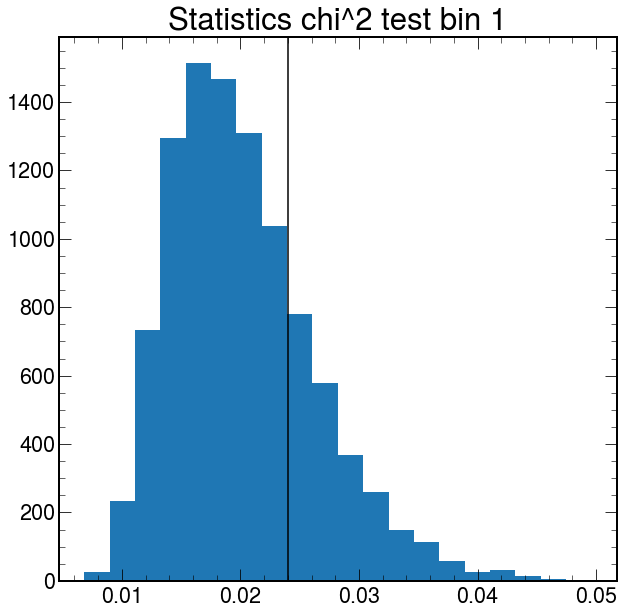

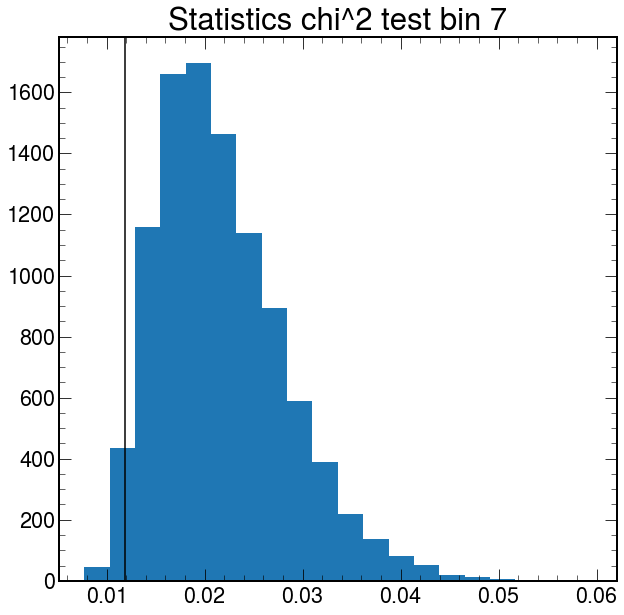

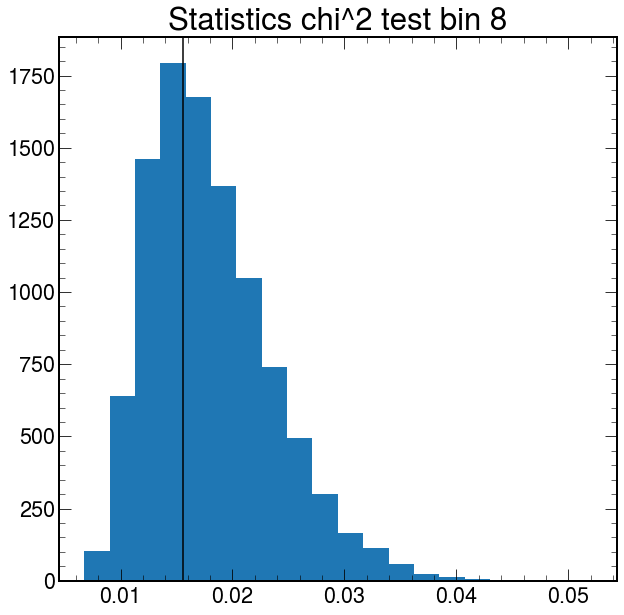

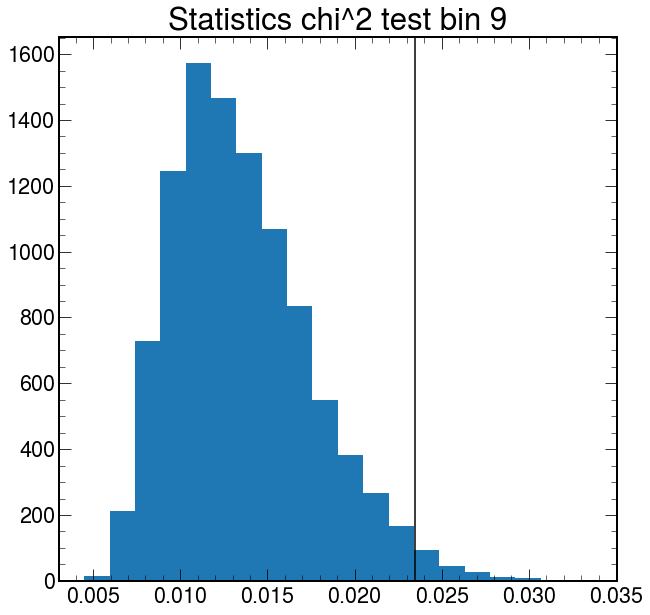

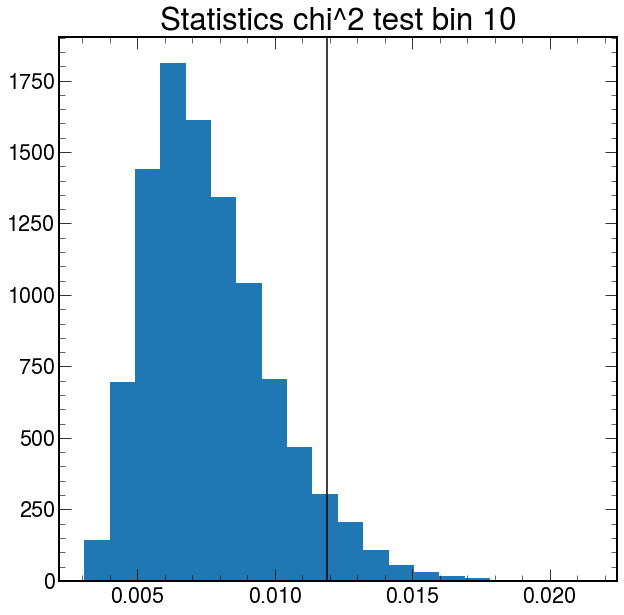

In [59]:
# plot of the statistic of Horacio's model samples
for b_name in bin_names:
    plt.hist(ks_h_test_s[b_name],bins=20)
    plt.title('Statistics chi^2 test bin ' + b_name)
    plt.axvline(x=ks_h_exp[b_name].statistic,color='black')
    plt.savefig(plot_path+'statistic_chi2_b'+b_name+'.png', dpi=150)
    plt.show()

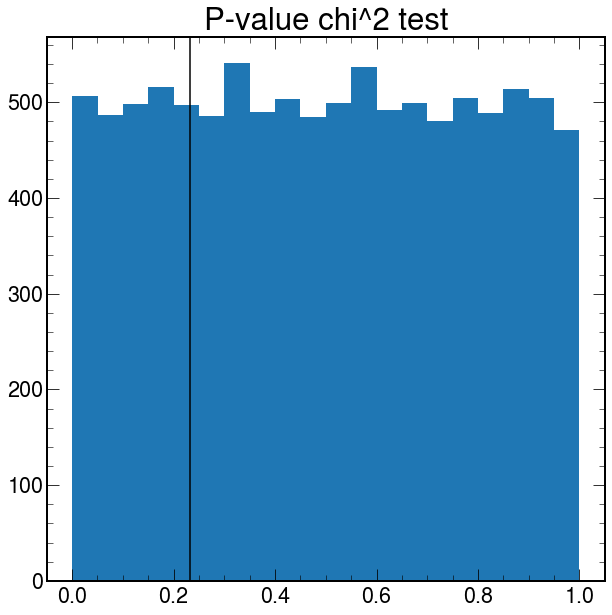

In [60]:
# plot of the pvalue of Horacio's model samples

plt.hist(ks_h_test_p['1'],bins=20)
plt.title('P-value chi^2 test')
plt.axvline(x=ks_h_exp['1'].pvalue,color='black')

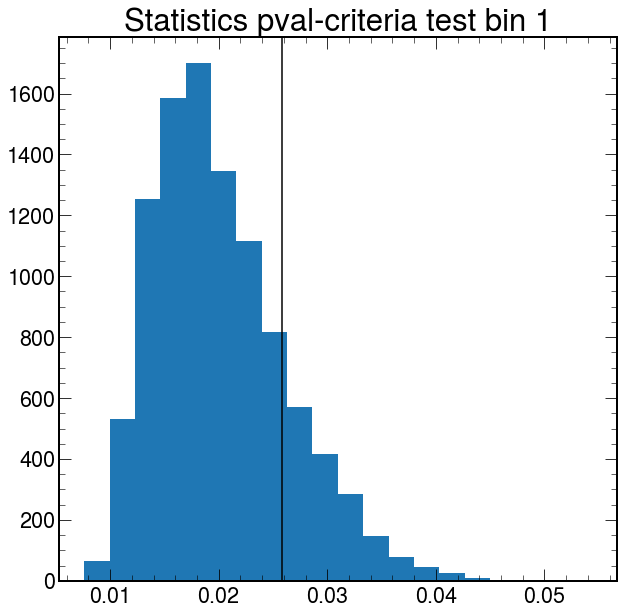

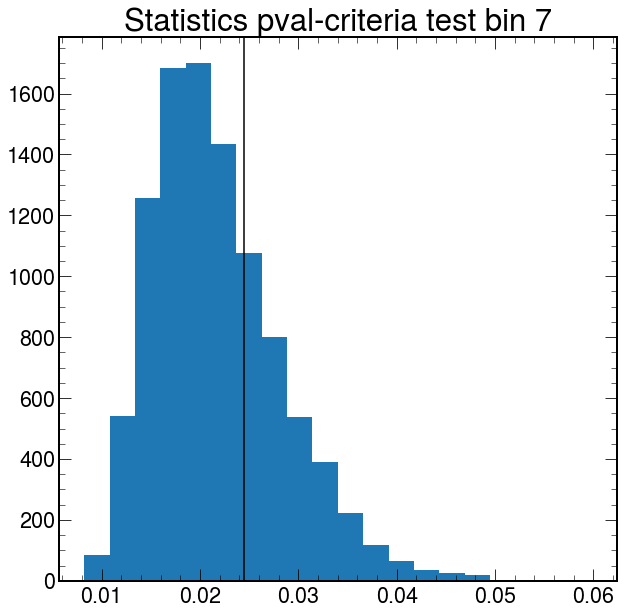

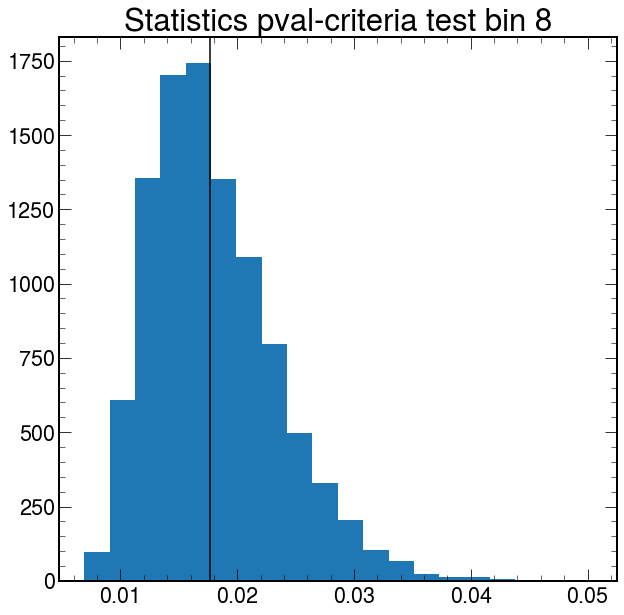

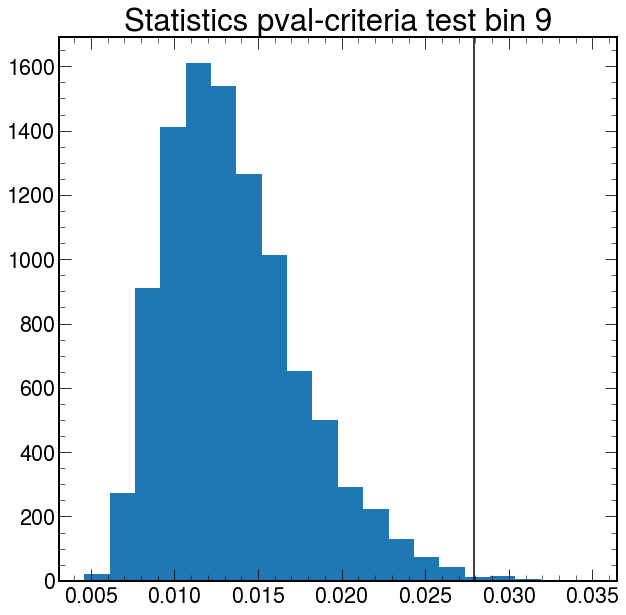

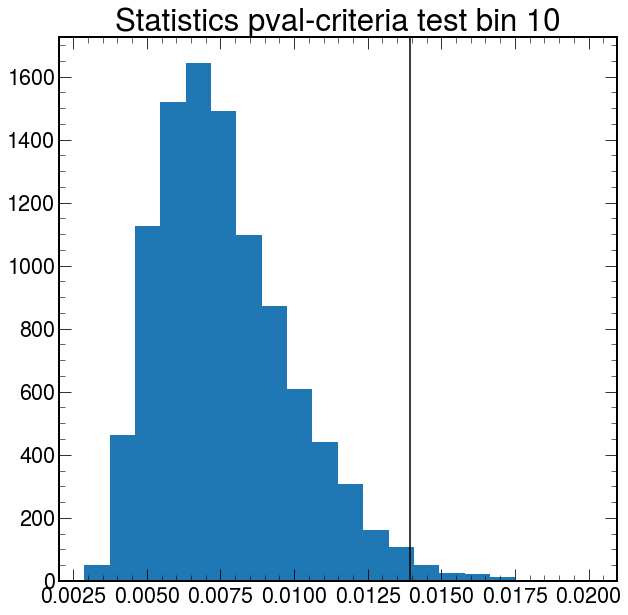

In [61]:
# plot of the statistic of my samples

for b_name in bin_names:
    plt.hist(ks_test_s[b_name],bins=20)
    plt.title('Statistics pval-criteria test bin ' + b_name)
    plt.axvline(x=ks_exp[b_name].statistic,color='black')
    plt.savefig(plot_path+'statistic_pval_b'+b_name+'.png', dpi=150)
    plt.show()

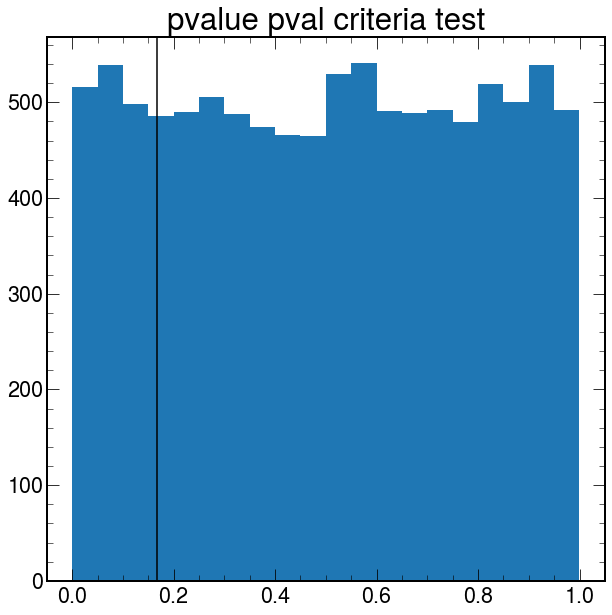

In [62]:
# plot of the pvalue of my samples

plt.hist(ks_test_p['1'],bins=20)
plt.title('pvalue pval criteria test')
plt.axvline(x=ks_exp['1'].pvalue,color='black')

# Integrating

In [63]:
calc_h_pval = {}
for b_name in bin_names:
    x=[]
    for i in range(n_samples):
        if ks_h_test_s[b_name][i]>=ks_h_exp[b_name].statistic:
            x.append(ks_h_test_s[b_name][i])
    calc_h_pval[b_name] = len(x)/n_samples
calc_h_pval

{'1': 0.2329, '7': 0.9766, '8': 0.6193, '9': 0.0189, '10': 0.0539}

In [64]:
calc_pval = {}
for b_name in bin_names:
    x=[]
    for i in range(n_samples):
        if ks_test_s[b_name][i]>=ks_exp[b_name].statistic:
            x.append(ks_test_s[b_name][i])
    calc_pval[b_name] = len(x)/n_samples
calc_pval

{'1': 0.1734, '7': 0.2946, '8': 0.458, '9': 0.0036, '10': 0.0122}

In [65]:
for b_name in bin_names:
    print('bin:', b_name, 'test: chi^2;', ks_h_exp[b_name])
    print('bin:', b_name, 'test: pval dist;', ks_exp[b_name])

bin: 1 test: chi^2; GofResult(statistic=0.02405424844984619, pvalue=0.23287914200137227)
bin: 1 test: pval dist; GofResult(statistic=0.025833311779109247, pvalue=0.16786002543220968)
bin: 7 test: chi^2; GofResult(statistic=0.01188055943753652, pvalue=0.9770263390492819)
bin: 7 test: pval dist; GofResult(statistic=0.024459359057558583, pvalue=0.2957891256202978)
bin: 8 test: chi^2; GofResult(statistic=0.015575614188283016, pvalue=0.6237360305759879)
bin: 8 test: pval dist; GofResult(statistic=0.017642137059849405, pvalue=0.46324059048666844)
bin: 9 test: chi^2; GofResult(statistic=0.023450058469550283, pvalue=0.023348478233126357)
bin: 9 test: pval dist; GofResult(statistic=0.02791234529050668, pvalue=0.003665240374292278)
bin: 10 test: chi^2; GofResult(statistic=0.011918065057761607, pvalue=0.050515650039347215)
bin: 10 test: pval dist; GofResult(statistic=0.013949369890155494, pvalue=0.012974782167327503)


In [66]:
# Making a comparison table
print ("{:<8} {:<24} {:<20} {:<24} {:<20}".format('Bin','pval-criteria', 'Integral', 'chi^2','Integral'))
for b_name in bin_names:
    print ("{:<8} {:<24} {:<20} {:<24} {:<20}".format(b_name, ks_exp[b_name].pvalue, calc_pval[b_name], ks_h_exp[b_name].pvalue, calc_h_pval[b_name]))

Bin      pval-criteria            Integral             chi^2                    Integral            
1        0.16786002543220968      0.1734               0.23287914200137227      0.2329              
7        0.2957891256202978       0.2946               0.9770263390492819       0.9766              
8        0.46324059048666844      0.458                0.6237360305759879       0.6193              
9        0.003665240374292278     0.0036               0.023348478233126357     0.0189              
10       0.012974782167327503     0.0122               0.050515650039347215     0.0539              
